In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)
processed_data = mrgy.reformat_gender_identity(processed_data)
df_gender = processed_data[processed_data['gender_identity'].isin(['Male', 'Female'])].dropna(subset=['rating'])

# treat rating as a categorical variable
df_gender['rating'] = df_gender['rating'].astype(str)

# theme for plots
sns.set_theme(style="whitegrid", font_scale=1.1)



# Question 4
What proportion of movies are rated differently by male and female viewers?


We now want to know how many movies show a statistically significant difference between male and female average ratings. 

The procedure to answer this question is as followed: 
1. Compare female and male 
2. Test their median and distributions 
3. Count number of movies such that p < 0.005
4. Divide by the total of movies to calculate the proportion.

In [2]:
df_gender.groupby('gender_identity')['rating'].describe()

,count,unique,top,freq
gender_identity,,,,
Female,32884,9,4.0,7178
Male,76765,9,4.0,18340


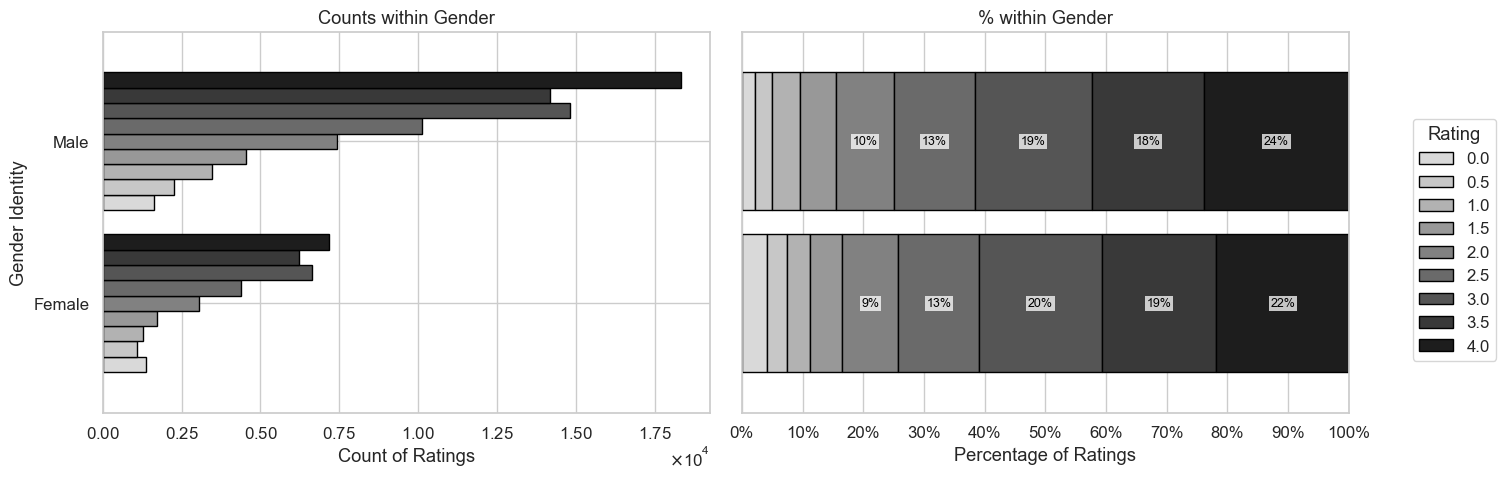

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, ScalarFormatter

# counts table
rating_counts = (
    df_gender.groupby(['gender_identity', 'rating'])
             .size()
             .unstack(fill_value=0)
             .sort_index(axis=1)  # ensure rating columns are ordered
)

# grayscale palette (light → dark)
n_cols = rating_counts.shape[1]
greys = plt.cm.Greys(np.linspace(0.25, 0.90, n_cols))

# (optional) make sure rating columns are treated as ordered categoricals
rating_counts.columns = pd.Categorical(rating_counts.columns, ordered=True)
rating_counts = rating_counts.sort_index(axis=1)

# per-group percentages (rows sum to 1)
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0)

# overall rating shares across all genders (for the Δ labels)
overall_share = rating_counts.sum(axis=0) / rating_counts.values.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- LEFT: counts (horizontal grouped) ---
rating_counts.plot(kind='barh', ax=axes[0], width=0.85, color=greys, edgecolor='black')
axes[0].set_title('Counts within Gender')
axes[0].set_xlabel('Count of Ratings')
axes[0].set_ylabel('Gender Identity')

sf = ScalarFormatter(useMathText=True)
sf.set_scientific(True)
sf.set_powerlimits((0, 0))      # always use scientific notation
axes[0].xaxis.set_major_formatter(sf)
axes[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)

# --- RIGHT: % within gender (horizontal 100% stacked) ---
rating_percentages.plot(kind='barh', ax=axes[1], stacked=True, width=0.85,
                        color=greys, edgecolor='black')
axes[1].set_title('% within Gender')
axes[1].set_xlabel('Percentage of Ratings')
axes[1].set_ylabel('Gender Identity')
axes[1].xaxis.set_major_formatter(PercentFormatter(1.0))
axes[1].set_xlim(0, 1)
# step 0.1
axes[1].xaxis.set_ticks(np.arange(0, 1.1, 0.1))

# ===== In-box annotations on percentage panel =====
min_width = 0.06  # label only segments >= 6% of the row width
y_positions = np.arange(len(rating_percentages.index))
cum_left = np.zeros(len(rating_percentages), dtype=float)

for col in rating_percentages.columns:
    widths = rating_percentages[col].values                         # segment widths per gender
    centers_x = cum_left + widths / 2.0
    delta_pp = (rating_percentages[col] - overall_share[col]) * 100 # Δ vs overall in p.p.
    labels = [f"{p:,.0%}" for p, d in zip(widths, delta_pp.values)]

    for y, w, x_center, label in zip(y_positions, widths, centers_x, labels):
        if w >= min_width:
            axes[1].text(
                x_center, y, label,
                ha='center', va='center', fontsize=9, color='black',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.75, pad=1.2)
            )

    cum_left += widths

# Shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()
axes[1].get_legend().remove()
fig.legend(handles, labels, title='Rating', loc='center left', bbox_to_anchor=(1.01, 0.5))

# remove the y label on the right panel and the y-axis values on the left panel
axes[1].set_ylabel('')
axes[1].set_yticklabels([])


plt.tight_layout()

# save to pdf
plt.savefig('../figures/gender_rating_distribution.pdf', bbox_inches='tight')


In [4]:
def total_variation_distance(p, q):
    # make sure they all have 0, 0.5, 1, .., 4 
    all_values = np.arange(0, 4.5, 0.5)
    p = p.reindex(all_values, fill_value=0)
    q = q.reindex(all_values, fill_value=0)
    p, q = np.asarray(p, dtype=float), np.asarray(q, dtype=float)
    p, q = p / p.sum(), q / q.sum()
    return 0.5 * np.sum(np.abs(p - q))

In [5]:
df_gender_movie = df_gender.groupby(['movie_name', 'year'])
df_gender_movie.size()

n_movies = len(df_gender_movie)

results = pd.DataFrame(columns=['prop', 'mw_p_value', 'mw_u_stat'])

for name, group in df_gender_movie:
    movie_name = name[0] + " (" + str(name[1]) + ")"
    # drop NA ratings
    ratings = group['rating'].dropna()
    
    # Split ratings by gender
    male_ratings = ratings[group['gender_identity'] == 'Male'].astype(float)
    female_ratings = ratings[group['gender_identity'] == 'Female'].astype(float)
    
    if len(male_ratings) > 0 and len(female_ratings) > 0:
        
        # check if ratings have na values
        if male_ratings.isna().sum() > 0 or female_ratings.isna().sum() > 0:
            print(f"NA values found in ratings for movie: {movie_name}")
            continue
        
        
        prop = total_variation_distance(male_ratings.value_counts().sort_index(), female_ratings.value_counts().sort_index())

        # Mann-Whitney U Test
        
        u_stat, p_value_mw = stats.mannwhitneyu(male_ratings, female_ratings, alternative='two-sided')

        results.loc[movie_name] = [prop, p_value_mw, u_stat]


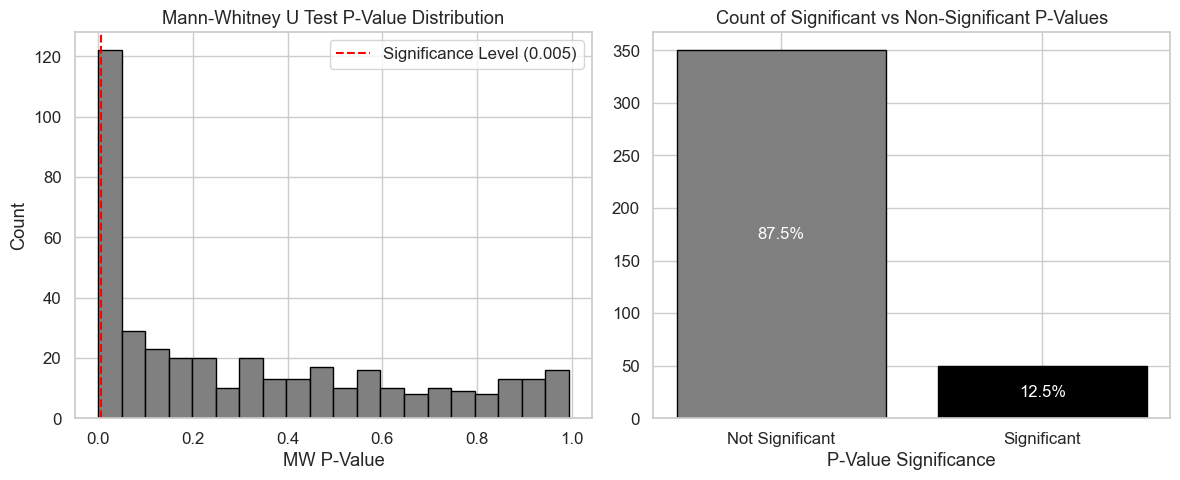

In [6]:
# one figure 
fig, ax = plt.subplots(1,2, figsize=(12, 5), dpi=100)

# distbution of p-values
results['mw_p_value'].hist(bins=20, ax=ax[0], color='gray', edgecolor='black')
ax[0].axvline(x=ALPHA, color='red', linestyle='--', label='Significance Level ({})'.format(ALPHA))
ax[0].set_title('Mann-Whitney U Test P-Value Distribution')
ax[0].set_xlabel('MW P-Value')
ax[0].set_ylabel('Count')
ax[0].legend()

# count of significant p-values and non-significant p-values
sig = results['mw_p_value'] < ALPHA
nonsig = results['mw_p_value'] >= ALPHA
ax[1].bar(['Not Significant', 'Significant'], [nonsig.sum(), sig.sum()], color=['gray', 'black'], edgecolor='black')
ax[1].set_title('Count of Significant vs Non-Significant P-Values')
ax[1].set_xlabel('P-Value Significance')

# annotations of the % 
total = len(results)
ax[1].text(0, nonsig.sum()/2, f"{(nonsig.sum()/total)*100:.1f}%", ha='center', va='center', color='white', fontsize=12)
ax[1].text(1, sig.sum()/2, f"{(sig.sum()/total)*100:.1f}%", ha='center', va='center', color='white', fontsize=12)

plt.tight_layout()
plt.savefig('../figures/gender_rating_mw_pvalue_distribution.pdf', bbox_inches='tight')

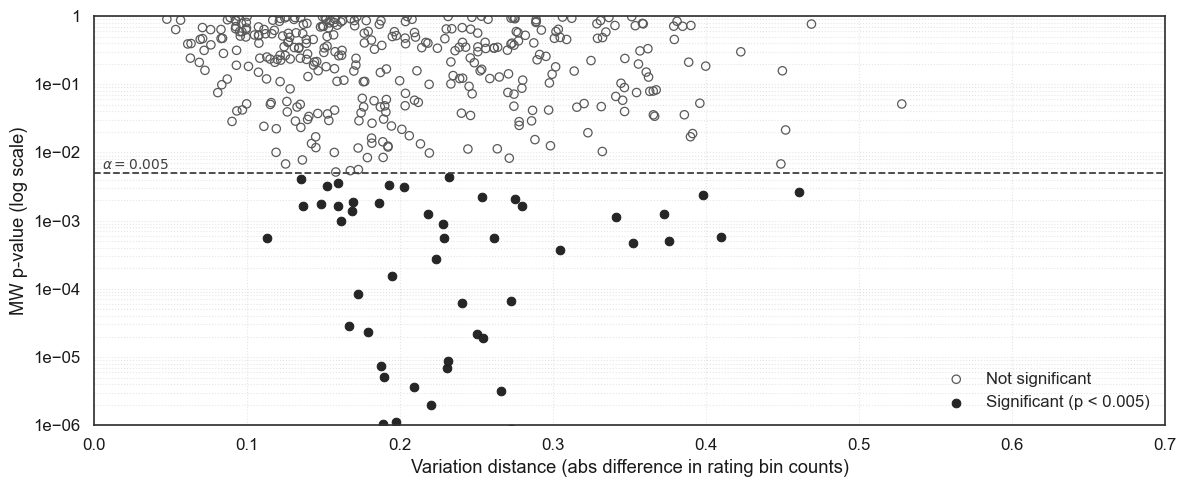

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter, ScalarFormatter

# --- params ---
ALPHA = 0.005              # significance threshold
ANNOTATE_TOP = 5           # how many significant points to label (set 0 to skip)

# pick a title column if present
title_cols = [c for c in ['movie','title','movie_title','name'] if c in results.columns]
title_col = title_cols[0] if title_cols else None

# masks
sig = results['mw_p_value'] < ALPHA
nonsig = ~sig

# figure
plt.rcParams.update({
    "axes.edgecolor": "0.2",
    "axes.labelcolor": "0.1",
    "xtick.color": "0.1",
    "ytick.color": "0.1",
    "font.size": 11,
})
fig, ax = plt.subplots(figsize=(12, 5), dpi=100)

# --- scatter (grayscale) ---
# non-significant: hollow markers
ax.scatter(results.loc[nonsig, 'prop'],
           results.loc[nonsig, 'mw_p_value'],
           s=36, facecolors='none', edgecolors='0.35', linewidths=0.9, label='Not significant')

# significant: filled dark markers
ax.scatter(results.loc[sig, 'prop'],
           results.loc[sig, 'mw_p_value'],
           s=40, c='0.15', edgecolors='0.1', linewidths=0.6, label=f'Significant (p < {ALPHA:g})')

# --- scales & guides ---
ax.set_yscale('log')
ax.set_xlim(0, 0.7)
ax.set_ylim(min(results['mw_p_value'].min() + 2e-6, 1e-6), 1.0)

ax.axhline(ALPHA, color='0.25', linestyle='--', lw=1.3)
ax.text(0.005, ALPHA*1.05, r'$\alpha={}$'.format(ALPHA), color='0.25', fontsize=10,
        va='bottom', ha='left')

ax.set_xlabel('Variation distance (abs difference in rating bin counts)')
ax.set_ylabel('MW p-value (log scale)')
ax.grid(True, which='both', axis='both', linestyle=':', linewidth=0.8, alpha=0.5)

# y tick formatter (clean log labels)
ax.yaxis.set_major_locator(LogLocator(base=10.0))
ax.yaxis.set_major_formatter(LogFormatter(10, labelOnlyBase=False))

# legend (monochrome-friendly)
leg = ax.legend(frameon=False, loc='lower right', title=None)

# --- annotate top-k significant points (smallest p-values) ---
if ANNOTATE_TOP and sig.any() and title_col is not None:
    topk = results.loc[sig].nsmallest(ANNOTATE_TOP, 'mw_p_value')
    for _, r in topk.iterrows():
        ax.annotate(str(r[title_col]),
                    xy=(r['prop'], r['mw_p_value']),
                    xytext=(6, 6),
                    textcoords='offset points',
                    fontsize=9, color='0.1',
                    bbox=dict(facecolor='1.0', edgecolor='0.8', boxstyle='round,pad=0.2'),
                    arrowprops=dict(arrowstyle='-', color='0.6', lw=0.8))

plt.tight_layout()

# optional: save vector for paper
# fig.savefig('../figures/mw_strength_significance.pdf', bbox_inches='tight')
# fig.savefig('../figures/mw_strength_significance.png', dpi=300, bbox_inches='tight')

fig.savefig('../figures/gender_rating_mw_strength_significance.pdf', dpi=300, bbox_inches='tight')


In [8]:
# proportion of significant movies and effect sizes
proportion_mw_significant = (results['mw_p_value'] < ALPHA).mean()

print(f"Proportion of movies with significant Mann-Whitney U test results (p < {ALPHA}): {proportion_mw_significant:.4f}")


Proportion of movies with significant Mann-Whitney U test results (p < 0.005): 0.1250


# Conclusion

Because ratings are discrete and non-normal, we compared gender-specific rating distributions using both a **Chi-Square test of independence** (treating ratings as categorical) and a **Mann-Whitney U test** (treating them as ordinal ranks).
At alpha = 0.005, 7.5% of movies showed significant gender effects by the Chi-Square test, 12.5% by the Mann-Whitney U test, and 7.25% by both methods—indicating that most films exhibit broadly similar rating patterns across genders, with only a small subset differing consistently across statistical frameworks.

Using Total Variation Distance (TVD) to quantify distributional differences between male and female ratings, we observe that:
1. Most movies cluster around TVD around 0.15 – 0.20 meaning male and female rating distributions differ by roughly 15–20 % on average.
2. The empirical CDF shows that about 70% of movies have TVD <= 0.25, indicating largely similar rating patterns between genders.
3. Only a small fraction of titles (< 10 %) exhibit both large probability-distribution differences and statistically significant gender effects (p < 0.005).

While male and female viewers occasionally diverge in how they rate specific movies, the overall pattern across all 400 films shows high overlap and small distributional differences. The total-variation analysis supports the inferential tests, that is most rating differences are minor in magnitude even when statistically detectable.